In [1]:
from google.colab import files
files.upload()

# Move the kaggle.json file to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [2]:
# Download Dataset from Kaggle
!kaggle datasets download -d alvinbintang/dataset-sibi
!unzip dataset-sibi.zip -d dataset-sibi

Streaming output truncated to the last 5000 lines.
  inflating: dataset-sibi/skripsi/B/1645946451.0243402_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645946454.6260056_U.jpg  
  inflating: dataset-sibi/skripsi/B/1645946456.4885087_F.jpg  
  inflating: dataset-sibi/skripsi/B/1645946460.4972847_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645946463.7729926_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645946467.532869_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645949132.0273714_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645949136.465165_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645949142.7455149_B.jpg  
  inflating: dataset-sibi/skripsi/B/1645949858.470701_Q.jpg  
  inflating: dataset-sibi/skripsi/B/1645949859.1649747_C.jpg  
  inflating: dataset-sibi/skripsi/B/1645949859.858002_Q.jpg  
  inflating: dataset-sibi/skripsi/B/1645949860.5160742_G.jpg  
  inflating: dataset-sibi/skripsi/B/1645949860.9303768_C.jpg  
  inflating: dataset-sibi/skripsi/B/1645949863.3891625_C.jpg  
  inflat

In [3]:
# Import Library

import os
import zipfile
import random
import tensorflow as tf
import csv
import numpy as np
import shutil
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from shutil import copyfile
from os import getcwd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

from tqdm import tqdm

In [4]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [5]:
# extract dataset
dataset_dir = 'dataset-sibi/skripsi'  # Ganti dengan path yang sesuai
img_height, img_width = 150, 150
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 4224 images belonging to 24 classes.
Found 1056 images belonging to 24 classes.


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [8]:
epochs = 100
validation_steps=validation_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=epochs
)

Epoch 1/100
132/132 [==============================] - 37s 226ms/step - loss: 3.1910 - accuracy: 0.0431 - val_loss: 3.1791 - val_accuracy: 0.0417
Epoch 2/100
132/132 [==============================] - 32s 245ms/step - loss: 3.1596 - accuracy: 0.0656 - val_loss: 3.1760 - val_accuracy: 0.0417
Epoch 3/100
132/132 [==============================] - 30s 226ms/step - loss: 3.0620 - accuracy: 0.1025 - val_loss: 2.7115 - val_accuracy: 0.1941
Epoch 4/100
132/132 [==============================] - 30s 224ms/step - loss: 2.6514 - accuracy: 0.1894 - val_loss: 2.3992 - val_accuracy: 0.2775
Epoch 5/100
132/132 [==============================] - 31s 236ms/step - loss: 2.4111 - accuracy: 0.2642 - val_loss: 2.2418 - val_accuracy: 0.3087
Epoch 6/100
132/132 [==============================] - 31s 234ms/step - loss: 2.2513 - accuracy: 0.3042 - val_loss: 2.1248 - val_accuracy: 0.3371
Epoch 7/100
132/132 [==============================] - 29s 224ms/step - loss: 2.1053 - accuracy: 0.3449 - val_loss: 2.0337 -

In [9]:
# Save the model
model.save('Model_SIBIPEDIA.h5')
print("Model saved successfully!")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


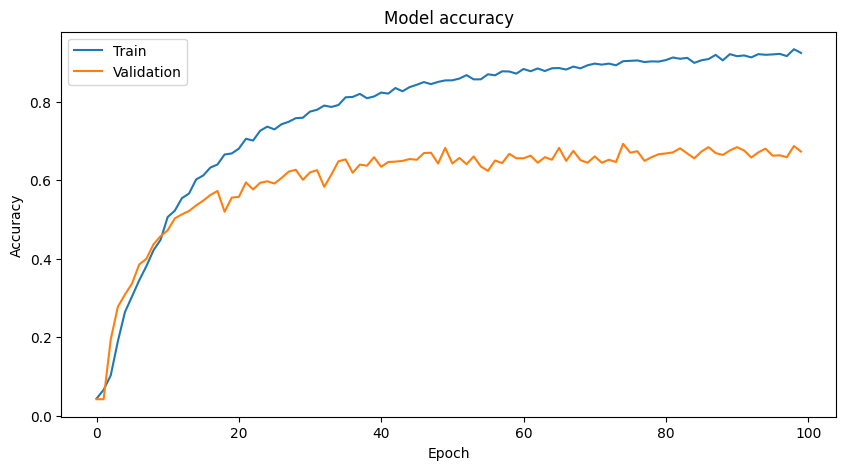

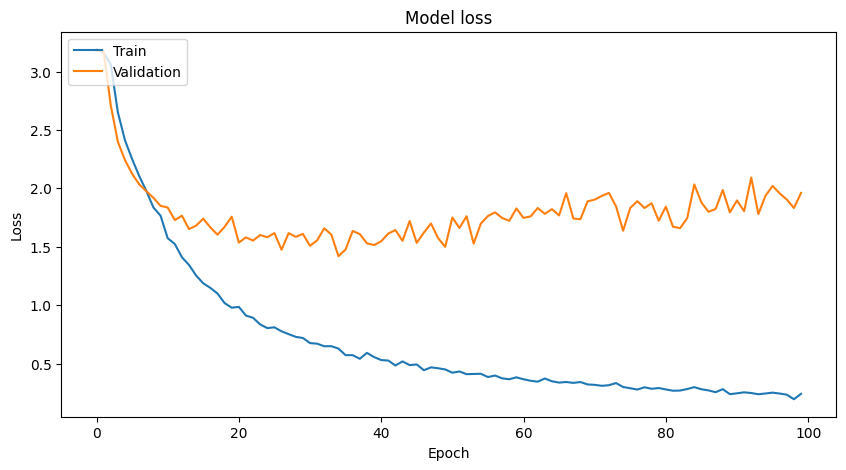

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
from keras.models import load_model

# load model
model = load_model('Model_SIBIPEDIA.h5')
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [12]:
# Evaluate on Validation data
scores = model.evaluate(validation_generator, verbose=1, steps=validation_steps*10, max_queue_size=3000, workers=1, use_multiprocessing=False)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

 33/330 [==>...........................] - ETA: 46s - loss: 1.8613 - accuracy: 0.6828

330/330 [==============================] - 5s 15ms/step - loss: 1.8613 - accuracy: 0.6828
evaluate accuracy: 68.28%


In [13]:
# Load the saved model
model = load_model('Model_SIBIPEDIA.h5')

# Function to make predictions on new images
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class] * 100
    class_labels = list(train_generator.class_indices.keys())
    predicted_label = class_labels[predicted_class]

    return predicted_label, confidence

In [16]:
# TRY 1
# Test the prediction function with a new image
img_path = '/content/dataset-sibi/skripsi/A/1645707869.4431655.jpg'  # Replace with the path to a new image
predicted_label, confidence = predict_image(img_path)
print(f'The predicted label for the image is: {predicted_label} ({confidence:.2f}%)')

1/1 [==============================] - 0s 19ms/step
The predicted label for the image is: A (95.31%)


In [17]:
# TRY 2
# Test the prediction function with a new image
img_path = '/content/dataset-sibi/skripsi/O/1645708888.7528524.jpg'  # Replace with the path to a new image
predicted_label, confidence = predict_image(img_path)
print(f'The predicted label for the image is: {predicted_label} ({confidence:.2f}%)')

1/1 [==============================] - 0s 17ms/step
The predicted label for the image is: O (99.96%)


In [18]:
# TRY 3
# Test the prediction function with a new image
img_path = '/content/dataset-sibi/skripsi/W/1645708743.1052845.jpg'  # Replace with the path to a new image
predicted_label, confidence = predict_image(img_path)
print(f'The predicted label for the image is: {predicted_label} ({confidence:.2f}%)')

1/1 [==============================] - 0s 16ms/step
The predicted label for the image is: W (89.89%)


In [19]:
# Load the saved Keras model
model = tf.keras.models.load_model('Model_SIBIPEDIA.h5')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model_sibi.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TFLite format and saved as 'model_sibi.tflite'")

Model successfully converted to TFLite format and saved as 'model_sibi.tflite'
